<a href="https://colab.research.google.com/github/RomainCoulon/Python_lib/blob/main/measurementModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measurement model

Import python modules

In [121]:
import numpy as np
import matplotlib.pyplot as plt

The measurement is based on a state space model including:
*   an expectation value *μ*
*   a gaussian white noise *ϵ* of variance *R*
*   a process noise (random gaussian walk) *δ* of variance *Q*
*   a determinstic drift *d* of slope *S*
*   a time step d*t*

The state space function gives a time series made of measurement values y and its decomposition with:
*   the true values of the process *x*
*   the deterministic component *d*

*t<sub>i<sub>* = *t<sub>i-1<sub>* + d*t*

*d<sub>i<sub>* = *d<sub>i-1<sub>* + *S*

*v<sub>i<sub>* = *v<sub>i-1<sub>* + *δ<sub>i<sub>*

*x<sub>i<sub>* = *x<sub>i-1<sub>* + *d<sub>i<sub>* + *v<sub>i<sub>*

*y<sub>i<sub>* = *x<sub>i<sub>* + *ϵ<sub>i<sub>*

with,

*d<sub>0<sub>* = *μ*

*v<sub>0<sub>* = 0

In [122]:
def stateSpace(N,mu,R,Q,S,dt):
    epsilon=np.random.normal(0,R,N)
    delta=np.random.normal(0,Q,N)
    t=np.arange(0,N,dt)
    x=[]  # random noise
    v=[]  # stochastic drift recurcive model
    y=[]  # measuremeent
    d=[]  # determinist drift recurvice model
    for i in range(N):
        if i==0:
            v.append(0)
            d.append(mu)
            x.append(v[-1]+d[-1])
            y.append(x[-1]+epsilon[i])
        else:
            v.append(v[-1]+delta[i])
            d.append(d[-1]+S)
            x.append(v[-1]+d[-1])
            y.append(x[-1]+epsilon[i])
    return y, x, d, t

Set the parameters of the model.

In [123]:
N=100
mu=10
R=1
Q=0.1
S=0
dt=1

A measurement *y* is generated.

In [124]:
y, x, d, t = stateSpace(N,mu,R,Q,S,dt)

A plot of the model is displayed. 

(array([ 6.,  7.,  8.,  9., 10., 11., 12.]),
 <a list of 7 Text major ticklabel objects>)

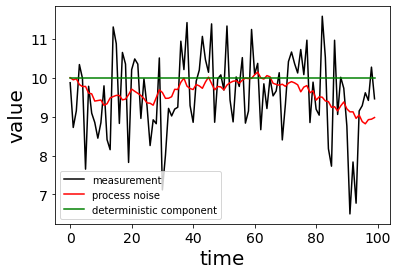

In [125]:
plt.figure("Plot measurement model")
plt.clf()
plt.plot(t,y,'-k',label=r"measurement")
plt.plot(t,x,'-r',label=r"process noise")
plt.plot(t,d,'-g',label=r"deterministic component")
plt.ylabel(r'value', fontsize=20)
plt.xlabel(r'time', fontsize=20)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)